In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image
import shutil

## Data Loading

In [2]:
#folder containing all images
data_dir=os.getcwd()+"/all_images/"
#destination folder
dest_dir=os.getcwd()+"/organized/"
#read the csv files to extract the classes
skin_df=pd.read_csv("HAM10000_metadata.csv")
print(skin_df['dx'].value_counts(normalize=True))
skin_df



nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [3]:
classes=list(skin_df['dx'].unique())
print(classes)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


In [5]:
#copy images to new folder
for i in classes:
    os.mkdir(dest_dir+str(i)+"/")
    samples=list(skin_df[skin_df['dx']==i]['image_id'].values)
    for sample_id in samples:
        shutil.copyfile((data_dir+"/"+sample_id+".jpg"),(dest_dir+i+"/"+sample_id+".jpg"))
        

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\elyes\\OneDrive\\Bureau\\PythonProject-CodeFiles\\ML code snippets\\CancerClassification/organized/bkl/'

### Create a data generator 

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Found 10015 images belonging to 7 classes.
nv


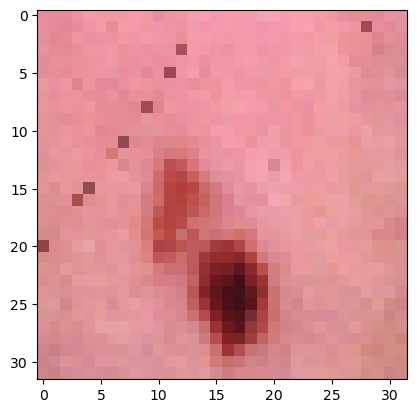

nv


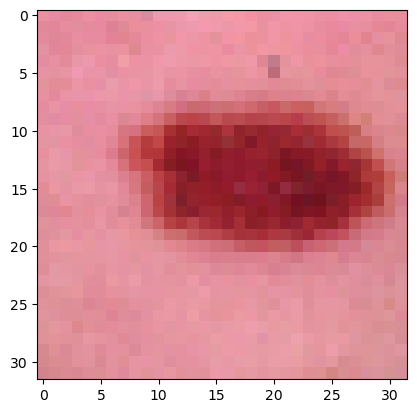

nv


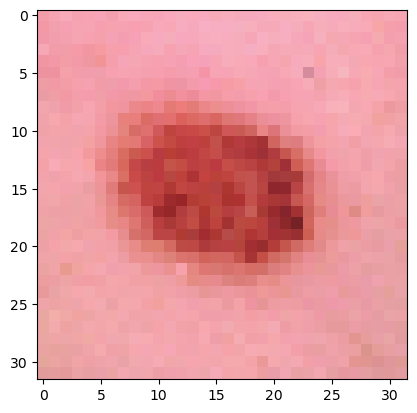

mel


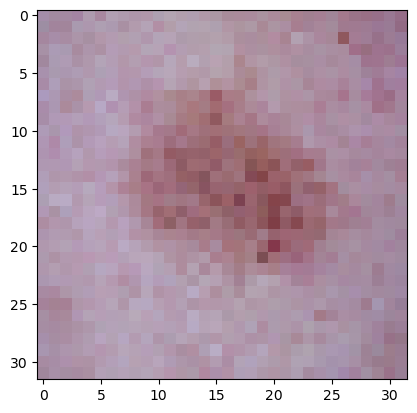

nv


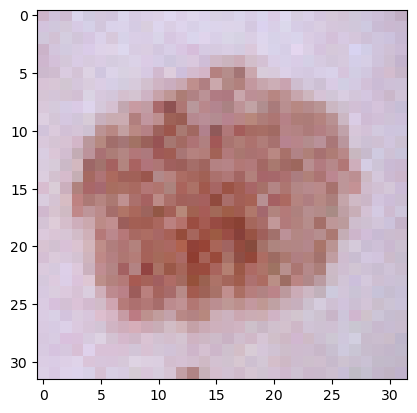

mel


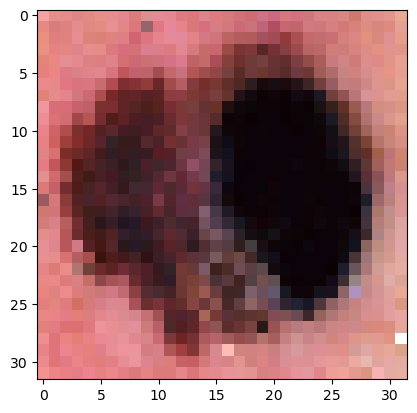

nv


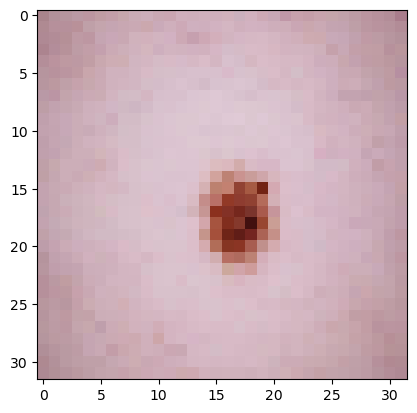

bkl


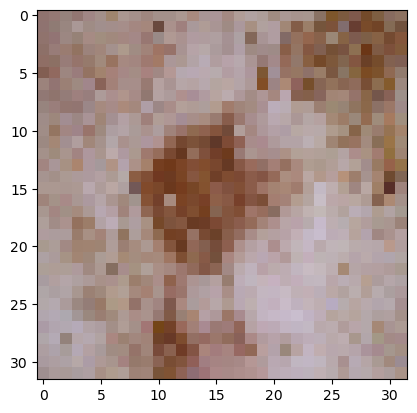

nv


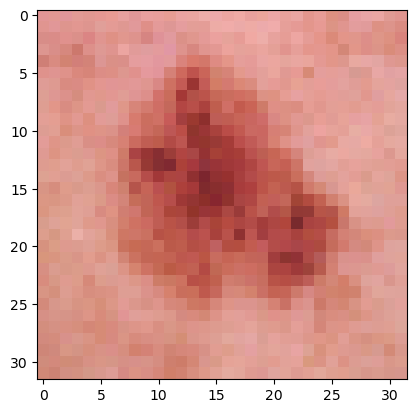

bkl


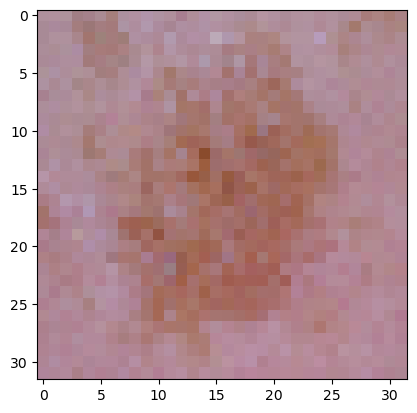

bkl


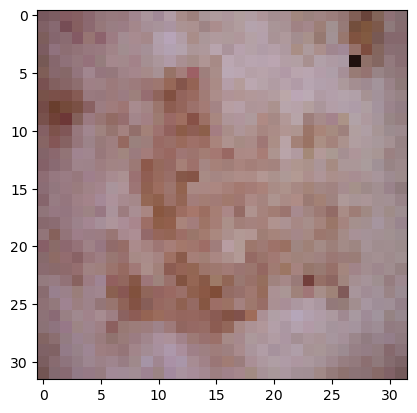

nv


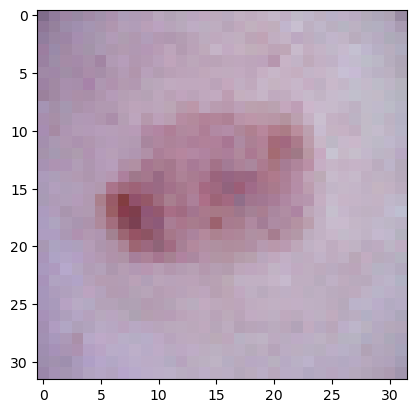

vasc


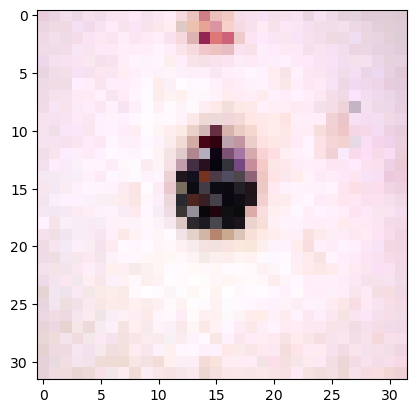

df


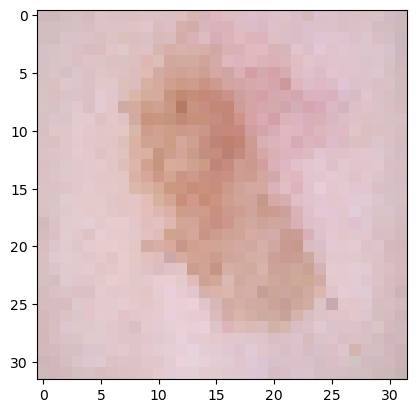

nv


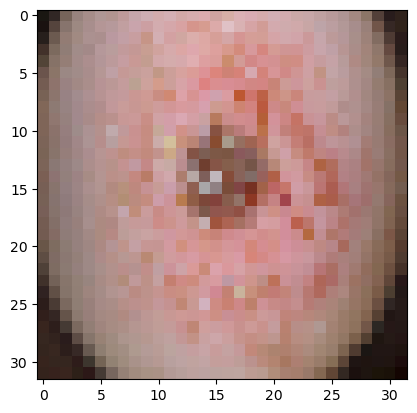

In [7]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
#define the train directory
train_dir=os.getcwd()+"/organized/"
train_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(32,32),
                                      subset='training')
val_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(32,32),
                                      subset='validation')

vis_datagen = ImageDataGenerator()
vis_data = vis_datagen.flow_from_directory(
    directory=train_dir,
    class_mode="categorical",
    batch_size=16,
    target_size=(32, 32),
    subset='training'
)

x, y = next(vis_data)
# Get class labels (reverse the key-value pair in the dictionary)
class_labels = {v: k for k, v in train_data.class_indices.items()}
for i in range(15):
    image=x[i].astype(int)
    print(class_labels[np.argmax(y[i])])
    plt.imshow(image)
    plt.show()
    


In [8]:
#modifying class weights to account for heavy class imbalance
class_counts=skin_df['dx'].value_counts().to_dict()
total=sum(class_counts.values())
class_weight={}
for class_name,class_idx in train_data.class_indices.items():
    weight=(1/class_counts[class_name])*(total/7)
    class_weight[class_idx]=weight
print(class_labels)
print(class_weight)

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
{0: 4.375273044997816, 1: 2.7834908282379103, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}


### Training w/o data augmentation
- decrease regularization
- transfer learning (Inception, VGG16)
- rethink of another resampling method 
- data augmentation


In [69]:
"""
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""
#define the model
num_classes=7
model=Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(MaxPool2D((2,2)))
# model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D())
# model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7,activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 2, 64)        

In [71]:
#checkpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath=os.getcwd()+'/models/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


In [72]:
#training
history=model.fit(train_data,
         epochs=30,
         validation_data=val_data,
         class_weight=class_weight,
         callbacks=[model_checkpoint_callback])

Epoch 1/30
501/501 [==============================] - 52s 105ms/step - loss: 1.4516 - acc: 0.4444 - val_loss: 1.2147 - val_acc: 0.5270
Epoch 2/30
501/501 [==============================] - 52s 104ms/step - loss: 1.3923 - acc: 0.4628 - val_loss: 1.2267 - val_acc: 0.5185
Epoch 3/30
501/501 [==============================] - 53s 106ms/step - loss: 1.3785 - acc: 0.4616 - val_loss: 1.0802 - val_acc: 0.5800
Epoch 4/30
501/501 [==============================] - 52s 103ms/step - loss: 1.3537 - acc: 0.4691 - val_loss: 1.3757 - val_acc: 0.4975
Epoch 5/30
501/501 [==============================] - 52s 103ms/step - loss: 1.3329 - acc: 0.4835 - val_loss: 1.2712 - val_acc: 0.5205
Epoch 6/30
501/501 [==============================] - 52s 103ms/step - loss: 1.3096 - acc: 0.4876 - val_loss: 1.1039 - val_acc: 0.5635
Epoch 7/30
501/501 [==============================] - 52s 103ms/step - loss: 1.2830 - acc: 0.4896 - val_loss: 1.2576 - val_acc: 0.4980
Epoch 8/30
501/501 [==============================] - 5

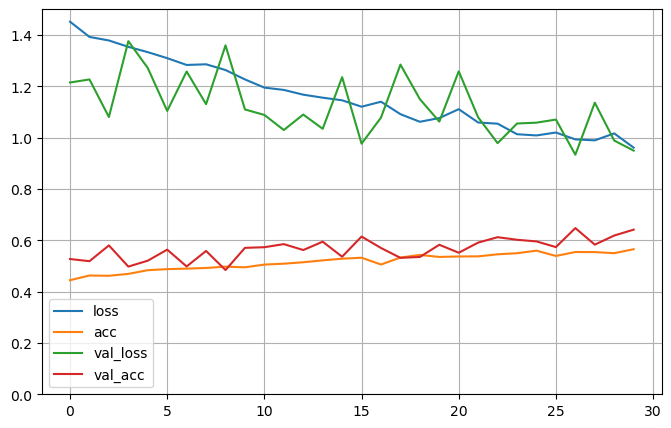

In [74]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()

### INCEPTIONV3


Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Found 10015 images belonging to 7 classes.
nv


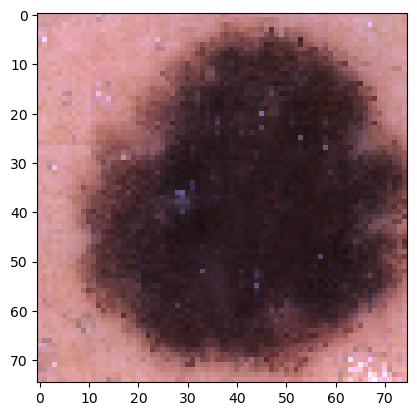

bkl


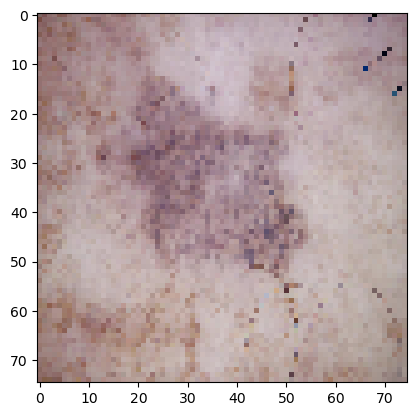

nv


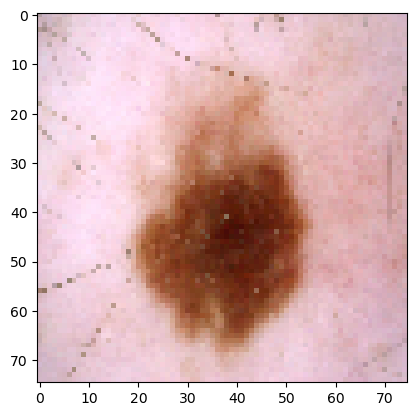

nv


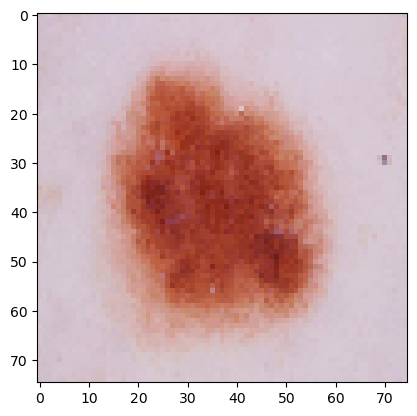

mel


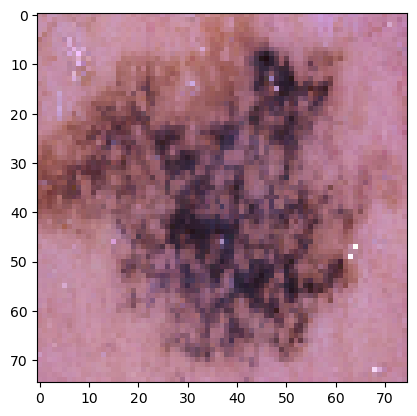

mel


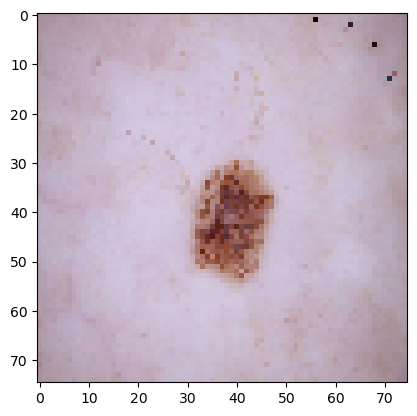

nv


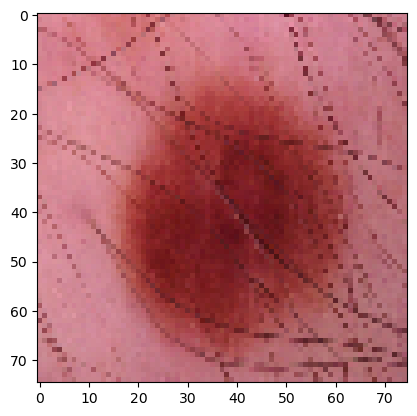

nv


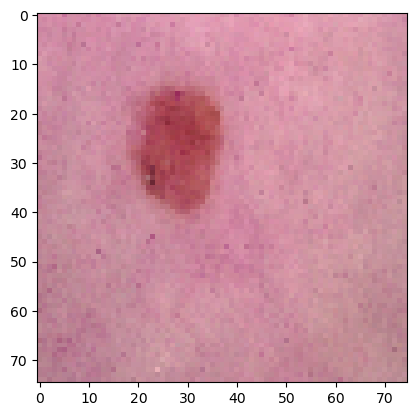

nv


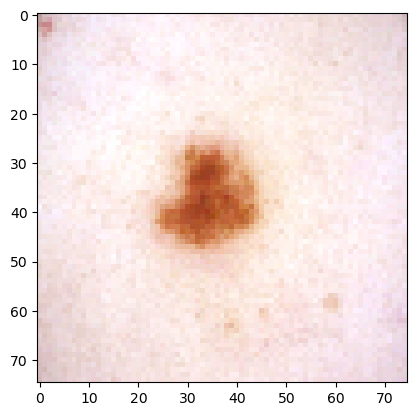

nv


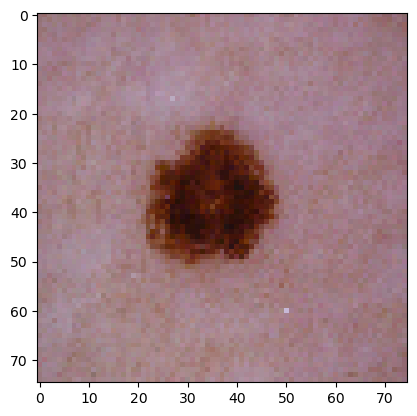

bcc


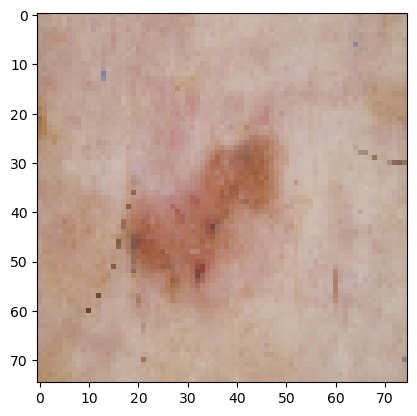

akiec


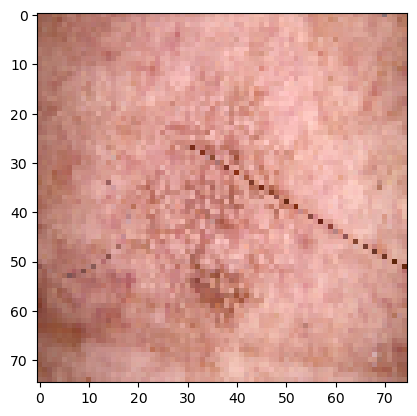

nv


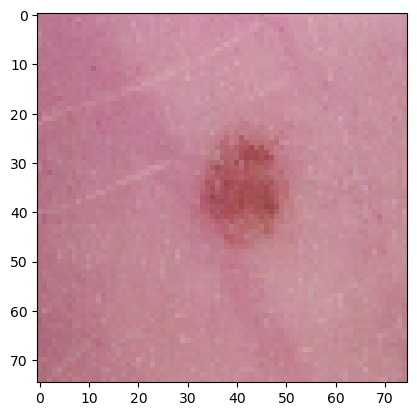

nv


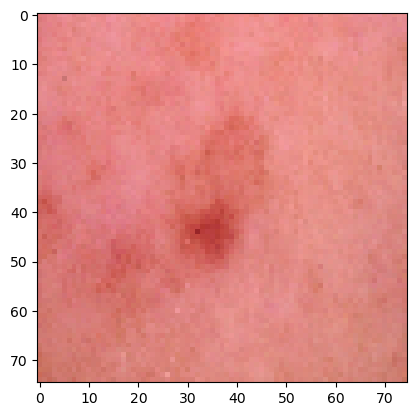

nv


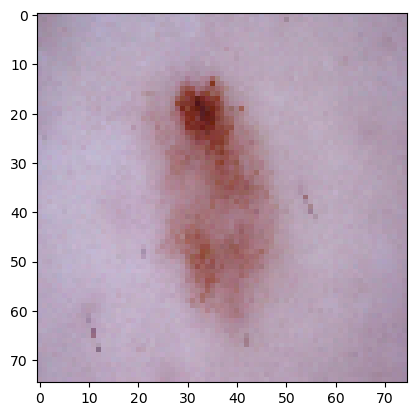

In [9]:
#creating a custom data_gen for INCEPTION as it only accepts images with a minimal resolution of 75x75
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
#define the train directory
train_dir=os.getcwd()+"/organized/"
inception_train_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(75,75),
                                      subset='training')
val_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(75,75),
                                      subset='validation')

vis_datagen = ImageDataGenerator()
vis_data = vis_datagen.flow_from_directory(
    directory=train_dir,
    class_mode="categorical",
    batch_size=16,
    target_size=(75, 75),
    subset='training'
)
x, y = next(vis_data)
# Get class labels (reverse the key-value pair in the dictionary)
class_labels = {v: k for k, v in inception_train_data.class_indices.items()}
for i in range(15):
    image=x[i].astype(int)
    print(class_labels[np.argmax(y[i])])
    plt.imshow(image)
    plt.show()

In [32]:
for image_batch, label_batch in inception_train_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (16, 75, 75, 3)
Label batch shape:  (16, 7)


In [27]:
#Transfer learning using Pretrained Keras Model 
inception=keras.applications.InceptionV3(weights='imagenet', include_top=False,
                                             input_shape=(75, 75, 3))
# Freeze layers from the base model
for layer in inception.layers:
    layer.trainable = False
print(inception.summary())


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [36]:
base_inputs = inception.input
x = keras.layers.GlobalAveragePooling2D()(inception.output)
# x = Dense(1024, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)
new_model = keras.Model(inputs=base_inputs, outputs=outputs)
new_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
print(new_model.summary())
inception_callback
checkpoint_filepath=os.getcwd()+'/models/'
inception_callback = ModelCheckpoint(
    filepath=checkpoint_filepath+'inception.h5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history=new_model.fit(inception_train_data,
              epochs=30,
              validation_data=val_data, 
              verbose=2,
              class_weight=class_weight,
              callbacks=[inception_callback])


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_282[0

501/501 - 59s - loss: 1.7467 - acc: 0.3834 - val_loss: 1.4254 - val_acc: 0.4970 - 59s/epoch - 117ms/step
Epoch 2/30
501/501 - 55s - loss: 1.3002 - acc: 0.5003 - val_loss: 1.4111 - val_acc: 0.4740 - 55s/epoch - 110ms/step
Epoch 3/30
501/501 - 56s - loss: 1.1008 - acc: 0.5447 - val_loss: 1.1850 - val_acc: 0.5695 - 56s/epoch - 111ms/step
Epoch 4/30
501/501 - 54s - loss: 0.9727 - acc: 0.5793 - val_loss: 1.5497 - val_acc: 0.4435 - 54s/epoch - 108ms/step
Epoch 5/30
501/501 - 55s - loss: 0.9268 - acc: 0.5961 - val_loss: 1.3838 - val_acc: 0.5080 - 55s/epoch - 109ms/step
Epoch 6/30
501/501 - 55s - loss: 0.8369 - acc: 0.6122 - val_loss: 1.0736 - val_acc: 0.6240 - 55s/epoch - 109ms/step
Epoch 7/30
501/501 - 56s - loss: 0.8052 - acc: 0.6193 - val_loss: 1.1125 - val_acc: 0.6255 - 56s/epoch - 112ms/step
Epoch 8/30
501/501 - 57s - loss: 0.7533 - acc: 0.6351 - val_loss: 1.1724 - val_acc: 0.5925 - 57s/epoch - 113ms/step
Epoch 9/30
501/501 - 55s - loss: 0.7067 - acc: 0.6475 - val_loss: 1.1228 - val_acc:

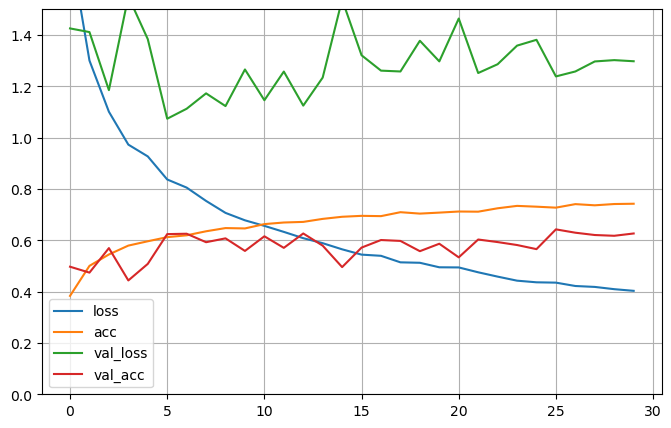

In [37]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()

## RESNET50

In [15]:
#creating a custom data_gen for RESNET50 
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
#define the train directory
train_dir=os.getcwd()+"/organized/"
resnet_train_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(100,100),
                                      subset='training')
val_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(100,100),
                                      subset='validation')

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [18]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable = False

# Create new model on top
base_inputs = base_model.input
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
# x = Dense(1024, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)

resnet_model = keras.Model(inputs=base_inputs, outputs=outputs)

# Compile and fit
resnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
checkpoint_filepath=os.getcwd()+'/models/'
resnet_callback = ModelCheckpoint(
    filepath=checkpoint_filepath+'resnet50.h5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history=resnet_model.fit(resnet_train_data, epochs=30, validation_data=val_data, verbose=2,
                 class_weight=class_weight, callbacks=[resnet_callback])


Epoch 1/30
501/501 - 57s - loss: 2.0458 - acc: 0.0927 - val_loss: 2.1262 - val_acc: 0.0315 - 57s/epoch - 113ms/step
Epoch 2/30
501/501 - 55s - loss: 2.0148 - acc: 0.1110 - val_loss: 2.1098 - val_acc: 0.0115 - 55s/epoch - 109ms/step
Epoch 3/30
501/501 - 55s - loss: 2.0117 - acc: 0.1386 - val_loss: 1.6673 - val_acc: 0.6560 - 55s/epoch - 110ms/step
Epoch 4/30
501/501 - 55s - loss: 1.9920 - acc: 0.1699 - val_loss: 2.4953 - val_acc: 0.0140 - 55s/epoch - 111ms/step
Epoch 5/30
501/501 - 54s - loss: 1.9793 - acc: 0.1464 - val_loss: 1.9082 - val_acc: 0.1230 - 54s/epoch - 108ms/step
Epoch 6/30
501/501 - 55s - loss: 1.9677 - acc: 0.1434 - val_loss: 2.1087 - val_acc: 0.0330 - 55s/epoch - 110ms/step
Epoch 7/30
501/501 - 55s - loss: 1.9524 - acc: 0.1658 - val_loss: 2.1432 - val_acc: 0.0160 - 55s/epoch - 109ms/step
Epoch 8/30
501/501 - 54s - loss: 1.9462 - acc: 0.1757 - val_loss: 1.6212 - val_acc: 0.5775 - 54s/epoch - 109ms/step
Epoch 9/30
501/501 - 55s - loss: 1.9497 - acc: 0.1984 - val_loss: 1.5860

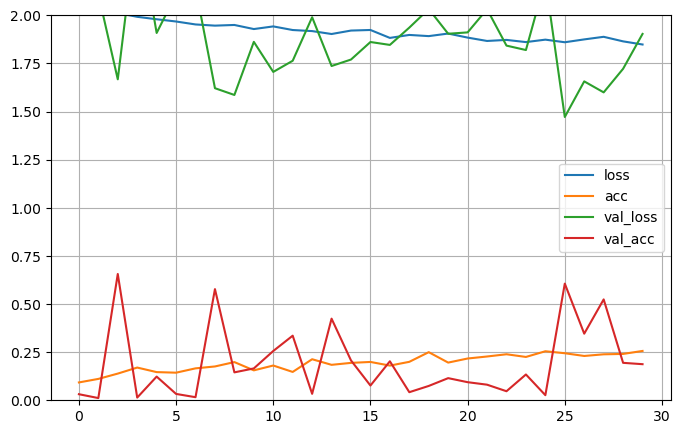

In [20]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

## Data Augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generator(target_size=(32, 32)):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,          # Rotate the image by a random angle within the range [-20, 20]
        shear_range=0.2,            # Shear angle in counter-clockwise direction as radians
        horizontal_flip=True,       # Randomly flip inputs horizontally
        validation_split=0.2        # For validation split
    )

    train_dir = os.getcwd() + "/organized/"
    train_data = datagen.flow_from_directory(
        directory=train_dir,
        class_mode="categorical",
        batch_size=16,
        target_size=target_size,
        subset='training'
    )

    val_data = datagen.flow_from_directory(
        directory=train_dir,
        class_mode="categorical",
        batch_size=16,
        target_size=target_size,
        subset='validation'
    )
    
    return train_data, val_data

# Usage example



In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_callback(model_name,file_path='./augmented/'):
    checkpoint_filepath = file_path + model_name + '.h5'
    callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        save_best_only=True
    )
    return callback

In [26]:
target_size = (75, 75)
train_data, val_data = create_data_generator(target_size)
callback=create_callback('inception.h5')
inception=keras.applications.InceptionV3(weights='imagenet', include_top=False,
                                             input_shape=(75, 75, 3))
# Freeze layers from the base model
for layer in inception.layers:
    layer.trainable = False
base_inputs = inception.input
x = keras.layers.GlobalAveragePooling2D()(inception.output)
# x = Dense(1024, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)
inception = keras.Model(inputs=base_inputs, outputs=outputs)
inception.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
inception.load_weights('./models/inception.h5')
history=inception.fit(train_data, epochs=30, validation_data=val_data, verbose=2,
                 class_weight=class_weight, callbacks=[callback])

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Epoch 1/30
501/501 - 67s - loss: 1.4300 - acc: 0.5298 - val_loss: 1.8870 - val_acc: 0.4465 - 67s/epoch - 133ms/step
Epoch 2/30
501/501 - 63s - loss: 1.3123 - acc: 0.5521 - val_loss: 1.9227 - val_acc: 0.4535 - 63s/epoch - 126ms/step
Epoch 3/30
501/501 - 64s - loss: 1.2866 - acc: 0.5402 - val_loss: 1.4351 - val_acc: 0.5500 - 64s/epoch - 127ms/step
Epoch 4/30
501/501 - 62s - loss: 1.2136 - acc: 0.5580 - val_loss: 1.8085 - val_acc: 0.4845 - 62s/epoch - 125ms/step
Epoch 5/30
501/501 - 62s - loss: 1.1973 - acc: 0.5527 - val_loss: 1.4040 - val_acc: 0.5585 - 62s/epoch - 125ms/step
Epoch 6/30
501/501 - 63s - loss: 1.1377 - acc: 0.5673 - val_loss: 1.4048 - val_acc: 0.5500 - 63s/epoch - 126ms/step
Epoch 7/30
501/501 - 67s - loss: 1.1624 - acc: 0.5581 - val_loss: 1.6222 - val_acc: 0.4900 - 67s/epoch - 134ms/step
Epoch 8/30
501/501 - 69s - loss: 1.0884 - acc: 0.5626 - val_loss: 1.6156 - val_acc: 0.5110 - 69s/epoch -

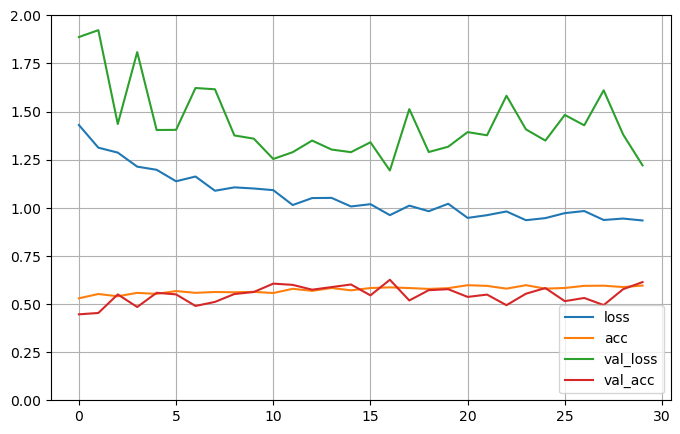

In [27]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

In [28]:
target_size = (100, 100)
train_data, val_data = create_data_generator(target_size)
callback=create_callback('resnet50')
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable = False

# Create new model on top
base_inputs = base_model.input
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
# x = Dense(1024, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)

resnet = keras.Model(inputs=base_inputs, outputs=outputs)
resnet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
resnet.load_weights('./models/resnet50.h5')
history=resnet.fit(train_data, epochs=30, validation_data=val_data, verbose=2,
                 class_weight=class_weight, callbacks=[callback])

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Epoch 1/30
501/501 - 73s - loss: 1.9888 - acc: 0.1336 - val_loss: 1.7365 - val_acc: 0.1555 - 73s/epoch - 146ms/step
Epoch 2/30
501/501 - 71s - loss: 1.9904 - acc: 0.1467 - val_loss: 1.5564 - val_acc: 0.6500 - 71s/epoch - 141ms/step
Epoch 3/30
501/501 - 71s - loss: 1.9750 - acc: 0.1547 - val_loss: 2.2565 - val_acc: 0.0125 - 71s/epoch - 142ms/step
Epoch 4/30
501/501 - 71s - loss: 1.9736 - acc: 0.1495 - val_loss: 1.9504 - val_acc: 0.0220 - 71s/epoch - 142ms/step
Epoch 5/30
501/501 - 70s - loss: 1.9782 - acc: 0.1652 - val_loss: 1.8240 - val_acc: 0.3215 - 70s/epoch - 141ms/step
Epoch 6/30
501/501 - 73s - loss: 1.9581 - acc: 0.1346 - val_loss: 1.7233 - val_acc: 0.4720 - 73s/epoch - 147ms/step
Epoch 7/30
501/501 - 74s - loss: 1.9477 - acc: 0.1951 - val_loss: 1.7321 - val_acc: 0.3300 - 74s/epoch - 148ms/step
Epoch 8/30
501/501 - 74s - loss: 1.9431 - acc: 0.1626 - val_loss: 1.7764 - val_acc: 0.2975 - 74s/epoch -

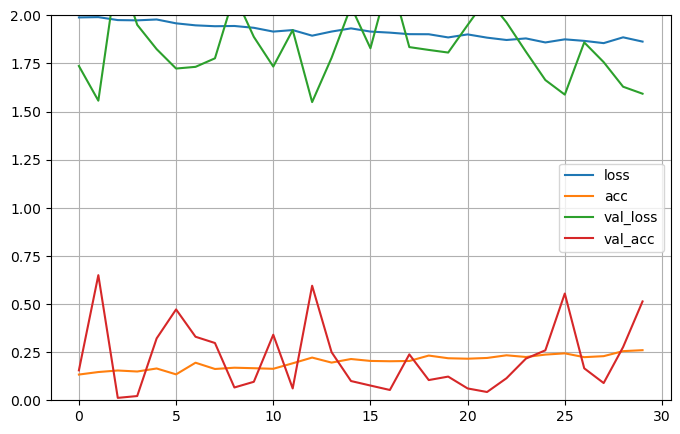

In [29]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

In [30]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
#define the train directory
train_dir=os.getcwd()+"/organized/"
train_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(32,32),
                                      subset='training')
val_data=datagen.flow_from_directory(directory=train_dir,
                                      class_mode="categorical",
                                      batch_size=16,
                                      target_size=(32,32),
                                      subset='validation')

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [31]:
##Custom model
"""
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""
#define the model
num_classes=7
model=Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(MaxPool2D((2,2)))
# model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D())
# model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7,activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 64)        

In [32]:
model.load_weights('./custom/')
callback=create_callback('custom')
history=model.fit(train_data,
         epochs=30,
         validation_data=val_data,
         class_weight=class_weight,
         callbacks=[callback])


Epoch 1/30
501/501 [==============================] - 57s 106ms/step - loss: 1.0236 - acc: 0.5334 - val_loss: 1.1092 - val_acc: 0.5455
Epoch 2/30
501/501 [==============================] - 55s 110ms/step - loss: 0.9711 - acc: 0.5511 - val_loss: 1.0308 - val_acc: 0.6165
Epoch 3/30
501/501 [==============================] - 55s 109ms/step - loss: 0.9633 - acc: 0.5587 - val_loss: 1.1556 - val_acc: 0.5750
Epoch 4/30
501/501 [==============================] - 54s 108ms/step - loss: 0.9538 - acc: 0.5697 - val_loss: 1.1159 - val_acc: 0.6040
Epoch 5/30
501/501 [==============================] - 55s 110ms/step - loss: 0.9824 - acc: 0.5621 - val_loss: 1.1013 - val_acc: 0.6135
Epoch 6/30
501/501 [==============================] - 54s 108ms/step - loss: 0.9764 - acc: 0.5560 - val_loss: 0.9942 - val_acc: 0.6270
Epoch 7/30
501/501 [==============================] - 54s 108ms/step - loss: 0.9162 - acc: 0.5774 - val_loss: 1.0663 - val_acc: 0.5855
Epoch 8/30
501/501 [==============================] - 5

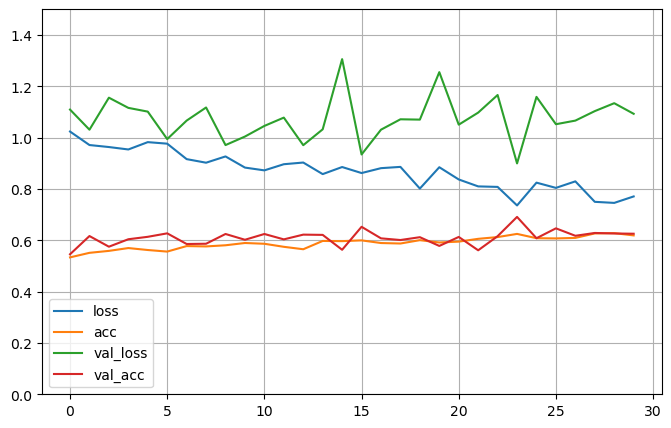

In [34]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()